In [1]:
import datetime
import os
import random
from math import ceil, pi
from collections import namedtuple

import keras
import plotly.io
import plotly.offline
import plotly.express as px
import polars as pl
import polars.selectors as cs
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

random.seed(3)
tf.random.set_seed(3)

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = "plotly_dark"
# plotly.io.renderers.default = "notebook_connected"

2024-05-12 15:52:20.964173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.15.0


In [2]:
# TODO After having trained a model, plot a heatmap store_nbr vs. family of loss values

# TODO After evaluation, retrain the model(s) on the test set before predicting

# TODO After selecting the best model for each key, retrain the model on the corresponding keys only.
# TODO This could be better as the model will only be used on those keys
# TODO -> need a large enough number of keys per model (which is a good thing anyway)

In [3]:
INPUT_DIR = os.path.abspath("input")  # directory with inputs from the competition

# TODO use 'steps' instead of 'length' for length of time sequences?
TARGET_LENGTH = 16  # length of the target sequences

METADATA_VARS = 4  # number of metadata variables
TIMESTEPS = 800  # number of timesteps to use in training

# training hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

BUFFER_SIZE = 1_000

# the Kaggle competition uses Root Mean Squared Logarithmic Error
LOSS = keras.losses.MeanSquaredLogarithmicError()

# DATA PREPARATION

In [5]:
Key = namedtuple("Key", ("store_nbr", "family"))
KeyStats = namedtuple("KeyStats", ("mean", "std"))

In [ ]:
class Scaler:
    def __init__(self, eps: float = 0.1):
        self.eps = eps
        self.map: dict[Key, KeyStats] = dict()

    def scale(self, key: Key, series: pl.Series) -> pl.Series:
        """Scales the series, omitting the target."""

        target = series.tail(TARGET_LENGTH)
        inputs = series.head(-TARGET_LENGTH)

        mean, std = inputs.mean(), inputs.std()
        std = 1.0 if std < self.eps else std  # type: ignore

        scaled_series = pl.concat([(inputs - mean) / std, target])

        self.map[key] = KeyStats(mean=mean, std=std)  # store the values for unscaling

        return scaled_series

    def unscale(self, keys: list[Key], pred: tf.Tensor) -> tf.Tensor:
        # pred has shape = (keys, TARGET_LENGTH, 1)

        kss = [self.map[key] for key in keys]
        mean = tf.reshape(tf.constant([ks.mean for ks in kss]), shape=(-1, 1, 1))
        std = tf.reshape(tf.constant([ks.std for ks in kss]), shape=(-1, 1, 1))

        return (pred * std) + mean

In [12]:
def _read_metadata_dataframes(timesteps: int, include_target: bool) -> pl.DataFrame:
    # read the oil prices and fill the missing dates
    meta_df = pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
    meta_df = (
        meta_df.select(pl.date_range(pl.col("date").min(), pl.col("date").max(), "1d"))
        .join(meta_df, on="date", how="outer")
        .drop("date_right")
        .interpolate()
        .fill_null(strategy="backward")
    )

    # add a weekday signal (cos and sin of the weekday)
    meta_df = (
        meta_df.with_columns(weekday=(2 * pi * (pl.col("date").dt.weekday() - 1) / 7))
        .with_columns(cos_wd=pl.col("weekday").cos(), sin_wd=pl.col("weekday").sin())
        .drop("weekday")
    )

    if not include_target:
        meta_df = meta_df.head(-TARGET_LENGTH)

    meta_df = meta_df.tail(timesteps + TARGET_LENGTH)

    # normalize the oil prices on the selected window
    # NOTE include the target in the normalization since we have it
    meta_df = meta_df.with_columns(
        (pl.col("dcoilwtico") - pl.col("dcoilwtico").mean())
        / pl.col("dcoilwtico").std()
    )

    meta_df = meta_df.with_columns(cs.numeric().cast(pl.Float32))

    return meta_df

In [13]:
def _read_key_dataframes(
    timesteps: int, include_target: bool
) -> tuple[dict[Key, pl.DataFrame], Scaler, pl.Series]:
    """Reads and preprocesses the key dataframes.

    The key dataframes have length `timesteps + TARGET_LENGTH`, with the last
    `TARGET_LENGTH` steps being the target (or test set if `include_target=False`).
    """

    # read dataframe containing the date and the shared metadata
    meta_df = _read_metadata_dataframes(timesteps, include_target)

    train_df = pl.read_csv(
        os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True
    ).drop("id")

    if include_target:
        target_df = (
            pl.read_csv(os.path.join(INPUT_DIR, "test.csv"), try_parse_dates=True)
            .with_columns(pl.lit(None).alias("sales"))
            .select(train_df.columns)
        )
        train_df = pl.concat([train_df, target_df], how="vertical")

    # keep only the most recent timesteps to make the training set and target
    timedelta = datetime.timedelta(timesteps + TARGET_LENGTH)
    train_df = train_df.filter(pl.col("date") > pl.col("date").max() - timedelta)

    dfs: dict[Key, pl.DataFrame] = dict()  # dict to store the key dataframes
    scaler = Scaler()  # scaler for the 'sales' columns

    # partition the train dataframe by key and process each key dataframe
    for key, df in train_df.partition_by(
        ["store_nbr", "family"], include_key=False, as_dict=True
    ).items():
        key = Key(*key)

        df = (
            df.join(meta_df, on="date", how="outer")
            .drop(["date", "date_right"])
            .interpolate()
            .fill_null(strategy="backward")
            .with_columns(  # min-max scaling (including target)
                (pl.col("onpromotion") - pl.col("onpromotion").min())
                / (pl.col("onpromotion").max() - pl.col("onpromotion").min() + 1)
            )
        )

        # scale the training 'sales' values (not the target)
        df = df.with_columns(sales=scaler.scale(key, df["sales"]))

        dfs[key] = df.cast(pl.Float32)

    return dfs, scaler, meta_df["date"]

In [17]:
class KeysDataFrame:
    def __init__(self, train_timesteps: int, include_target: bool):
        self.train_steps = train_timesteps

        dfs, scaler, date = _read_key_dataframes(train_timesteps, include_target)

        self._cols = next(iter(dfs.values())).columns
        self._date, self._scaler = date, scaler

        # make a tensor with dims = (key, time, feature)
        self._data = tf.stack([tf.constant(df) for df in dfs.values()], axis=0)

        # compute the index of each dataframe along the key dimension
        self._key_index = {key: ind for ind, key in enumerate(dfs.keys())}

    def get_training_data(self, keys: list[Key]) -> tf.Tensor:
        """Returns the training data (without target) for the selected keys."""

        data = tf.slice(self._data, begin=[0, 0, 0], size=[-1, self.train_steps, -1])

        return tf.gather(data, indices=[self._key_index[key] for key in keys], axis=0)

    def get_last_window(
        self, keys: list[Key], input_length: int
    ) -> tuple[tf.Tensor, tf.Tensor]:
        """Returns the data of last window (input + target)."""

        data = tf.slice(
            self._data,
            begin=[0, self.train_steps - input_length, 0],
            size=[-1, -1, -1],
        )

        return tf.gather(data, indices=[self._key_index[key] for key in keys], axis=0)

    def unscale(self, keys: list[Key], pred: tf.Tensor) -> tf.Tensor:
        return self._scaler.unscale(keys, pred)

    def __getitem__(self, key: Key) -> pl.DataFrame:
        data = tf.squeeze(tf.gather(self._data, self._key_index[key], axis=0))
        df = pl.DataFrame(data.numpy(), schema=self._cols)

        return df.insert_column(0, self._date)

    @property
    def keys(self) -> list[Key]:
        return list(self._key_index.keys())

---

## Dataset creation

In [18]:
@tf.function(
    input_signature=[
        tf.TensorSpec(shape=(None, None, 1 + METADATA_VARS), dtype=tf.float32)
    ]
)
def split_batch_window(
    window_batch: tf.Tensor,
) -> tuple[tuple[tf.Tensor, tf.Tensor, tf.Tensor], tf.Tensor]:
    """Splits a batch of window into a batch of (inputs, target) pairs."""

    # split time
    x_vars, y_vars = tf.split(window_batch, [-1, TARGET_LENGTH], axis=1)  # type: ignore

    # split features
    x_sale, x_meta = tf.split(x_vars, [1, -1], axis=-1)  # type: ignore
    y_sale, y_meta = tf.split(y_vars, [1, -1], axis=-1)  # type: ignore

    return (x_sale, x_meta, y_meta), y_sale

In [19]:
class KeysDataset:
    def __init__(
        self,
        kdf: KeysDataFrame,
        input_length: int,
        keys: list[Key],
        train_ratio: float = 0.8,
    ):
        self.window_length = input_length + TARGET_LENGTH

        # split the total number of windows according to the ratio
        total_windows = kdf.train_steps - 2 * self.window_length + 2
        train_windows = int(total_windows * train_ratio)
        valid_windows = total_windows - train_windows

        # compute the number of timesteps corresponding to the number of training windows
        train_timesteps = train_windows + self.window_length - 1

        data = kdf.get_training_data(keys)
        data = tf.transpose(data, perm=[1, 0, 2])  # dims = (time, key, feature)

        train_data, valid_data = tf.split(data, [train_timesteps, -1], axis=0)  # type: ignore

        self.train = self._make_dataset(train_data)
        self.valid = self._make_dataset(valid_data)

        # compute the number of batches in each dataset (for self.length)
        self.train_batches = ceil(train_windows * len(keys) / BATCH_SIZE)
        self.valid_batches = ceil(valid_windows * len(keys) / BATCH_SIZE)

    def _make_dataset(self, data: tf.Tensor) -> tf.data.Dataset:
        ds = tf.data.Dataset.from_tensor_slices(data)  # spec = (keys, features)

        # window the time dimension -> spec = (window_length, keys, features)
        ds = ds.window(size=self.window_length, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda window: window.batch(self.window_length))

        # -> spec = (keys, window_length, features)
        ds = ds.map(lambda xs: tf.transpose(xs, perm=[1, 0, 2]))

        # split the key dimension into tensors -> spec = (window_length, features)
        ds = ds.flat_map(tf.data.Dataset.from_tensor_slices)

        return (
            ds.shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(split_batch_window, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
        )

    # TODO return only train_batches? if no need for valid_batches
    @property
    def length(self) -> dict[str, int]:
        return {"train": self.train_batches, "valid": self.valid_batches}

---

# STRATEGY AND MODEL BLUEPRINT

In [20]:
# TODO explain architecture and put picture here

In [21]:
# NOTE Give up on the Decoupling Network which does not work.
# NOTE The decoupling is done by the TimeNet anyways, so no need for an extra network
# NOTE unless we want to do something very specific (e.g. decoupling by hand).
#
# NOTE Right now, we split the x_vars in the KDS and then concatenate them in the model.
# NOTE This is a bit inefficient but illustrates what happens well.

In [22]:
def make_coupnet() -> keras.Model:
    seq = keras.Sequential(
        [
            keras.Input(shape=(TARGET_LENGTH, 1 + METADATA_VARS)),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1, kernel_initializer="ones"),
        ]
    )

    y_Zvar = keras.Input(shape=(TARGET_LENGTH, 1), name="Y-ZVariable")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")
    y_conc = keras.layers.Concatenate(axis=-1, name="concatenate")([y_Zvar, y_meta])
    y_coup = seq(y_conc)

    return keras.Model(inputs=[y_Zvar, y_meta], outputs=y_coup, name="CoupNet")

In [23]:
def make_model(timenet: keras.Model, coupnet: keras.Model, name: str) -> keras.Model:
    """Constructs a model from individual components."""

    x_sale = keras.Input(shape=(None, 1), name="X-Sales")
    x_meta = keras.Input(shape=(None, METADATA_VARS), name="X-Metadata")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")

    x_vars = keras.layers.Concatenate(axis=-1, name="concatenate")([x_sale, x_meta])

    y_Zvar = timenet(x_vars)  # -> (batch, y_steps, 1)
    y_pred = coupnet([y_Zvar, y_meta])  # -> (batch, y_steps, 1)

    return keras.Model(inputs=[x_sale, x_meta, y_meta], outputs=y_pred, name=name)

## Print model architecture

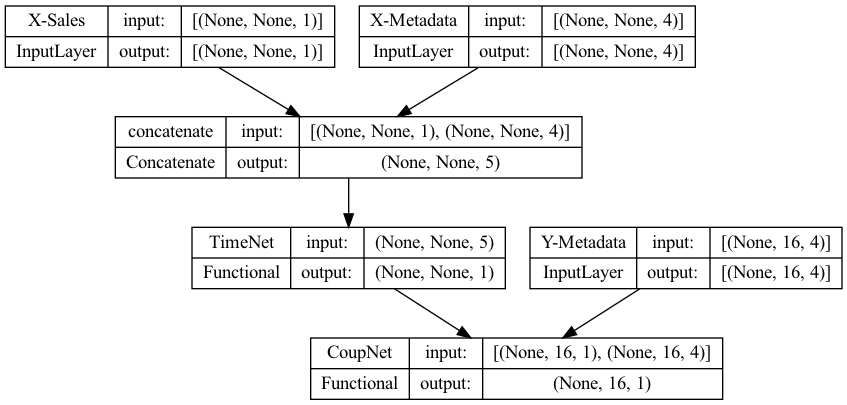

In [24]:
def _make_dummy_timenet() -> keras.Model:
    x_Zvar = keras.Input(shape=(None, 1 + METADATA_VARS))
    y_Zvar = x_Zvar[:, -TARGET_LENGTH:, 0, tf.newaxis]  # type: ignore

    return keras.Model(inputs=x_Zvar, outputs=y_Zvar, name="TimeNet")


def _make_dummy_coupnet() -> keras.Model:
    y_Zvar = keras.Input(shape=(TARGET_LENGTH, 1), name="Y-ZVariable")
    y_meta = keras.Input(shape=(TARGET_LENGTH, METADATA_VARS), name="Y-Metadata")

    return keras.Model(inputs=[y_Zvar, y_meta], outputs=y_Zvar, name="CoupNet")


# make a dummy model whose output is the tail of the input sales values
dummy_model = make_model(
    timenet=_make_dummy_timenet(), coupnet=_make_dummy_coupnet(), name="DummyModel"
)

keras.utils.plot_model(
    dummy_model, show_shapes=True, to_file="_dummy.png", expand_nested=False
)

# TESTING THE MODELS

In [25]:
kdf = KeysDataFrame(500, include_target=False)  # take fewer timesteps for testing

In [26]:
EPOCHS = 3
SPLIT = 3

# NOTE sample keys not at random to ensure repeatability
# NOTE Take the keys spread across the entire range of stores and families
keys = kdf.keys[::10]

kds = KeysDataset(kdf, input_length=64, keys=keys)

In [27]:
def make_dense_timenet(input_length: int) -> keras.Model:
    name = "DENS-3x32"

    return keras.Sequential(
        [
            keras.Input(shape=(input_length, 1 + METADATA_VARS)),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Flatten(),
            keras.layers.Dense(TARGET_LENGTH),
            keras.layers.Reshape((TARGET_LENGTH, 1)),
        ],
        name=name + "-TimeNet",
    )

---

In [ ]:
model = make_model(make_dense_timenet(64), make_coupnet(), name="test")
model.compile(loss=LOSS, optimizer=keras.optimizers.Adam(learning_rate=1e-4))


hist = model.fit(
    kds.train.repeat(),
    validation_data=kds.valid,
    epochs=EPOCHS * SPLIT,
    steps_per_epoch=kds.length["train"] // SPLIT,
)

In [118]:
px.line(pl.DataFrame(hist.history), y=["loss", "val_loss"]).show()

In [ ]:
# NOTE Try a model without the metadata

nmd_timenet = keras.Sequential(
    [
        keras.Input(shape=(64, 1 + METADATA_VARS)),
        keras.layers.Lambda(lambda xs: xs[:, :, 0, tf.newaxis]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(TARGET_LENGTH),
        keras.layers.Reshape((TARGET_LENGTH, 1)),
    ],
    name="NoMetadata" + "-TimeNet",
)

model = make_model(nmd_timenet, make_coupnet(), "NoMetadata")

model.compile(loss=LOSS, optimizer=keras.optimizers.Adam(learning_rate=1e-4))

hist = model.fit(
    kds.train.repeat(),
    validation_data=kds.valid,
    epochs=EPOCHS * SPLIT,
    steps_per_epoch=kds.length["train"] // SPLIT,
    verbose=0,
)

px.line(pl.DataFrame(hist.history), y=["loss", "val_loss"]).show()

# EVALUATION

In [44]:
kdf = KeysDataFrame(200, False)

In [45]:
def predict(
    model: keras.Model, kdf: KeysDataFrame, keys: list[Key], input_length: int
) -> tuple[tf.Tensor, tf.Tensor]:
    inputs, y_sale = split_batch_window(kdf.get_last_window(keys, input_length))  # type: ignore

    # predict and unscale the predictions
    y_pred = model(inputs)  # -> shape = (keys, TARGET_LENGTH, 1)

    y_pred = kdf.unscale(keys, y_pred)

    key_losses = tf.reduce_mean(keras.losses.MSLE(y_pred, y_sale), axis=-1)

    return y_pred, key_losses

In [55]:
# NOTE The Dummy model from above gives a baseline which uses the last 16 days of the training set as predictions.
# NOTE It performs better than all LSTM models from the previous version.
#
# TODO Rename Dummy -> Baseline and use it as one of our models.
#
# TODO Make a model using the Baseline TimeNet and a CoupNet to see if the metadata
# TODO only can give good predictions.


pred, losses = predict(dummy_model, kdf, kdf.keys, 32)

baseline_df = pl.DataFrame(
    losses[tf.newaxis].numpy(), schema=[str(key) for key in kdf.keys]
)

baseline_df.transpose().describe()

statistic,column_0
str,f64
"""count""",1782.0
"""null_count""",0.0
"""mean""",0.485343
"""std""",1.341245
"""min""",0.0
"""25%""",0.110689
"""50%""",0.255857
"""75%""",0.555402
"""max""",24.525038
